In [1]:
import sys
sys.path.append('C:\\Users\\Patrick\\Documents\\GitHub\\ICDeepLearning\\Scripts')
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets, models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

from utils import path
from DataVis import createInputFigure
from NNUtils import *
from NNCreationAux import *
from SSVEPDataset import SSVEPDataset
from SSVEPDataloader import *

from sklearn import preprocessing
import os
import time
import copy

In [3]:
%load_ext autoreload
%autoreload 2

***

#### Auxiliary Functions

In [4]:
def barPlot(table):
    models = table.loc[:]['model']
    best_val_acc = table.loc[:]['best val acc']
    
    N = len(models)
    ind = np.arange(N)
    
    plt.style.use('ggplot')
    fig, ax = plt.subplots()
    
    fig.set_size_inches(12, 5)
    plt.xticks(ind, models, rotation = 25, size = 14)
    plt.yticks(size = 15)
    
    ax.bar(ind, best_val_acc, color = 'slateblue', width = 0.5)
    
    
def buildTable(picType, dataType):
    dataPath = path('Models\\'+picType)
    modelsTitles = os.listdir(dataPath())[1:]
    table = pd.DataFrame(index = range(len(modelsTitles)), columns = ['model', 'best val acc', 'best val loss', 'training acc', 'training loss'])

    for model, k in zip(modelsTitles, list(range(len(modelsTitles)))):

        Path = path(dataPath/model+'/'+dataType)
        Training, Validation = torch.load(Path/'stats512.pth')['512']

        for i in range(len(Training[0])):
            Training[0][i] = Training[0][i].item()
            Validation[0][i] = Validation[0][i].item()

        bestValAccArg = np.argmax(Validation[0])

        table.loc[k] = [model, Validation[0][bestValAccArg], Validation[1][bestValAccArg],
                               Training[0][bestValAccArg], Training[1][bestValAccArg]]

    table = table.sort_values(by = 'best val acc', ascending = False, ignore_index = True)
    return table

***

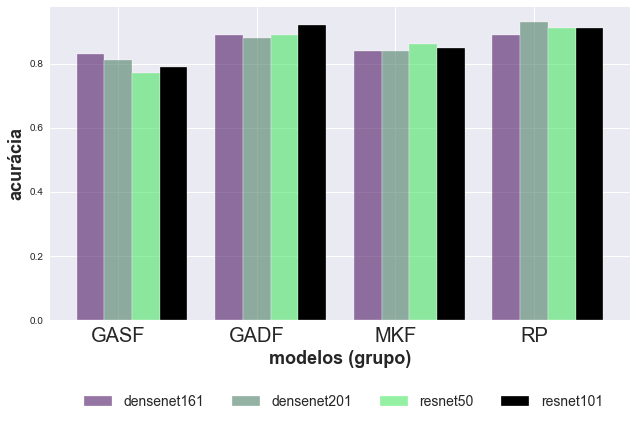

In [13]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
    
fig, ax = plt.subplots()
fig.set_size_inches(9, 6)

# set width of bar
barWidth = 0.2
 
# set height of bar
bars1 = [0.83, 0.89, 0.84, 0.89]
bars2 = [0.81, 0.88, 0.84, 0.93]
bars3 = [0.77, 0.89, 0.86, 0.91]
bars4 = [0.79, 0.92, 0.85, 0.91]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
ax.bar(r1, bars1, color=(0.3,0.1,0.4,0.6), width=barWidth, edgecolor='white', label='densenet161')
ax.bar(r2, bars2, color=(0.3,0.5,0.4,0.6), width=barWidth, edgecolor='white', label='densenet201')
ax.bar(r3, bars3, color=(0.3,0.9,0.4,0.6), width=barWidth, edgecolor='white', label='resnet50')
ax.bar(r4, bars4, color='black', width=barWidth, edgecolor='white', label='resnet101')
 
# Add xticks on the middle of the group bars
plt.xlabel('modelos (grupo)', fontweight='bold')
plt.ylabel('acurácia', fontweight = 'bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['GASF', 'GADF', 'MKF', 'RP'])

ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)
ax.xaxis.set_tick_params(labelsize = 20)

ax.grid(True, which = 'both')
 
# Create legend & Show graphic
ax.legend(fontsize = 14, bbox_to_anchor=(.975, -0.2), ncol = 4)
fig.tight_layout()
fig.savefig('plot.png')

***
#### Tables

Gramian Angular Summation Field

          model best val acc best val loss training acc training loss
0   densenet161     0.827839      0.633519     0.993132     0.0366975
1     resnet152     0.826007      0.690557     0.995879     0.0258854
2   densenet169     0.818681       0.70353     0.993132      0.029269
3      resnet34     0.811355       0.80769     0.995421     0.0175232
4      resnet18     0.809524      0.881107      0.99359     0.0218048
5   densenet201     0.807692      0.813463     0.990842     0.0341137
6   densenet121     0.804029      0.717805     0.986264     0.0579804
7     googlenet     0.791209      0.826886     0.989927     0.0526342
8     resnet101     0.791209      0.744109     0.992674     0.0240675
9      resnet50     0.771062      0.811559     0.962454      0.120791
10        vgg11     0.705128       0.97788     0.919414      0.293853
11        vgg13     0.694139      0.998538      0.93544      0.254939
12        vgg16     0.684982       1.17172     0.912088      0.306161
13      alexnet     

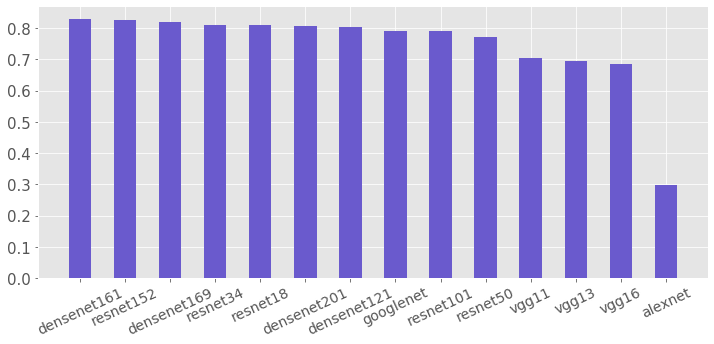

In [128]:
table = buildTable('gasf', 'cca128')
print(table)
barPlot(table)

Gramian Angular Difference Field

***

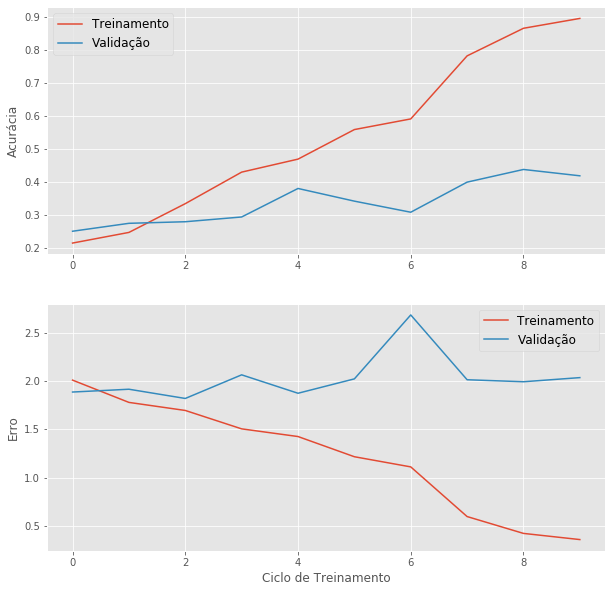

In [24]:
plt.style.use('ggplot')
fig, axs = plt.subplots(nrows = 2, ncols = 1)

fig.set_size_inches(10, 10)
fig.subplots_adjust(hspace = 0.2)
size = len(Training[0])

axs[0].plot(range(size), Training[0], label = 'Treinamento'); axs[1].plot(range(size), Training[1], label = 'Treinamento')
axs[0].plot(range(size), Validation[0], label = 'Validação'); axs[1].plot(range(size), Validation[1], label = 'Validação')

axs[1].set(xlabel = 'Ciclo de Treinamento')
axs[0].set(ylabel = 'Acurácia')
axs[1].set(ylabel = 'Erro')
axs[0].legend(fontsize = 12)
axs[1].legend(fontsize = 12)

fig.savefig('figure.png')

In [ ]:
plt.style.use('ggplot')
folder = 'cca'
dataType = '512'
size = ['64' ,'96', '128', '160', '192', '224', '256', '288']

print(dataType)
for k in size:
    path = 'Models\\resnet34\\'+folder+k+'\\stats'+dataType+".pth"
    stats = torch.load(path)[dataType]
    trainAcc = stats[0][0]
    valAcc = stats[1][0]
    trainLoss = stats[0][1]
    valLoss = stats[1][1]
    
    for i in range(len(trainAcc)):
        trainAcc[i]  = trainAcc[i].item() 
        valAcc[i] = valAcc[i].item()
    
    print(k)
    print("Max Train Accuracy: {} - Max Val Accuracy: {}".format(max(trainAcc), max(valAcc)))
    
    fig, axs = plt.subplots(nrows = 2, ncols = 1)      
    fig.set_size_inches(10, 10)
    fig.subplots_adjust(hspace = 0.2)
    size = len(trainAcc)
    
    axs[0].plot(range(size), trainAcc, label = 'Treinamento')
    axs[1].plot(range(size), trainLoss, label = 'Treinamento')
    axs[0].plot(range(size), valAcc, label = 'Validação')
    axs[1].plot(range(size), valLoss, label = 'Validação')
        
    axs[1].set(xlabel = 'Ciclo de Treinamento')
    axs[0].set(ylabel = 'Acurácia')
    axs[1].set(ylabel = 'Erro')
    axs[0].legend(fontsize = 12)
    axs[1].legend(fontsize = 12)
    
    fig.suptitle(k, fontsize = 16)
    
    fig.savefig('figure'+folder+k+'.png')

***

Raw Time Series

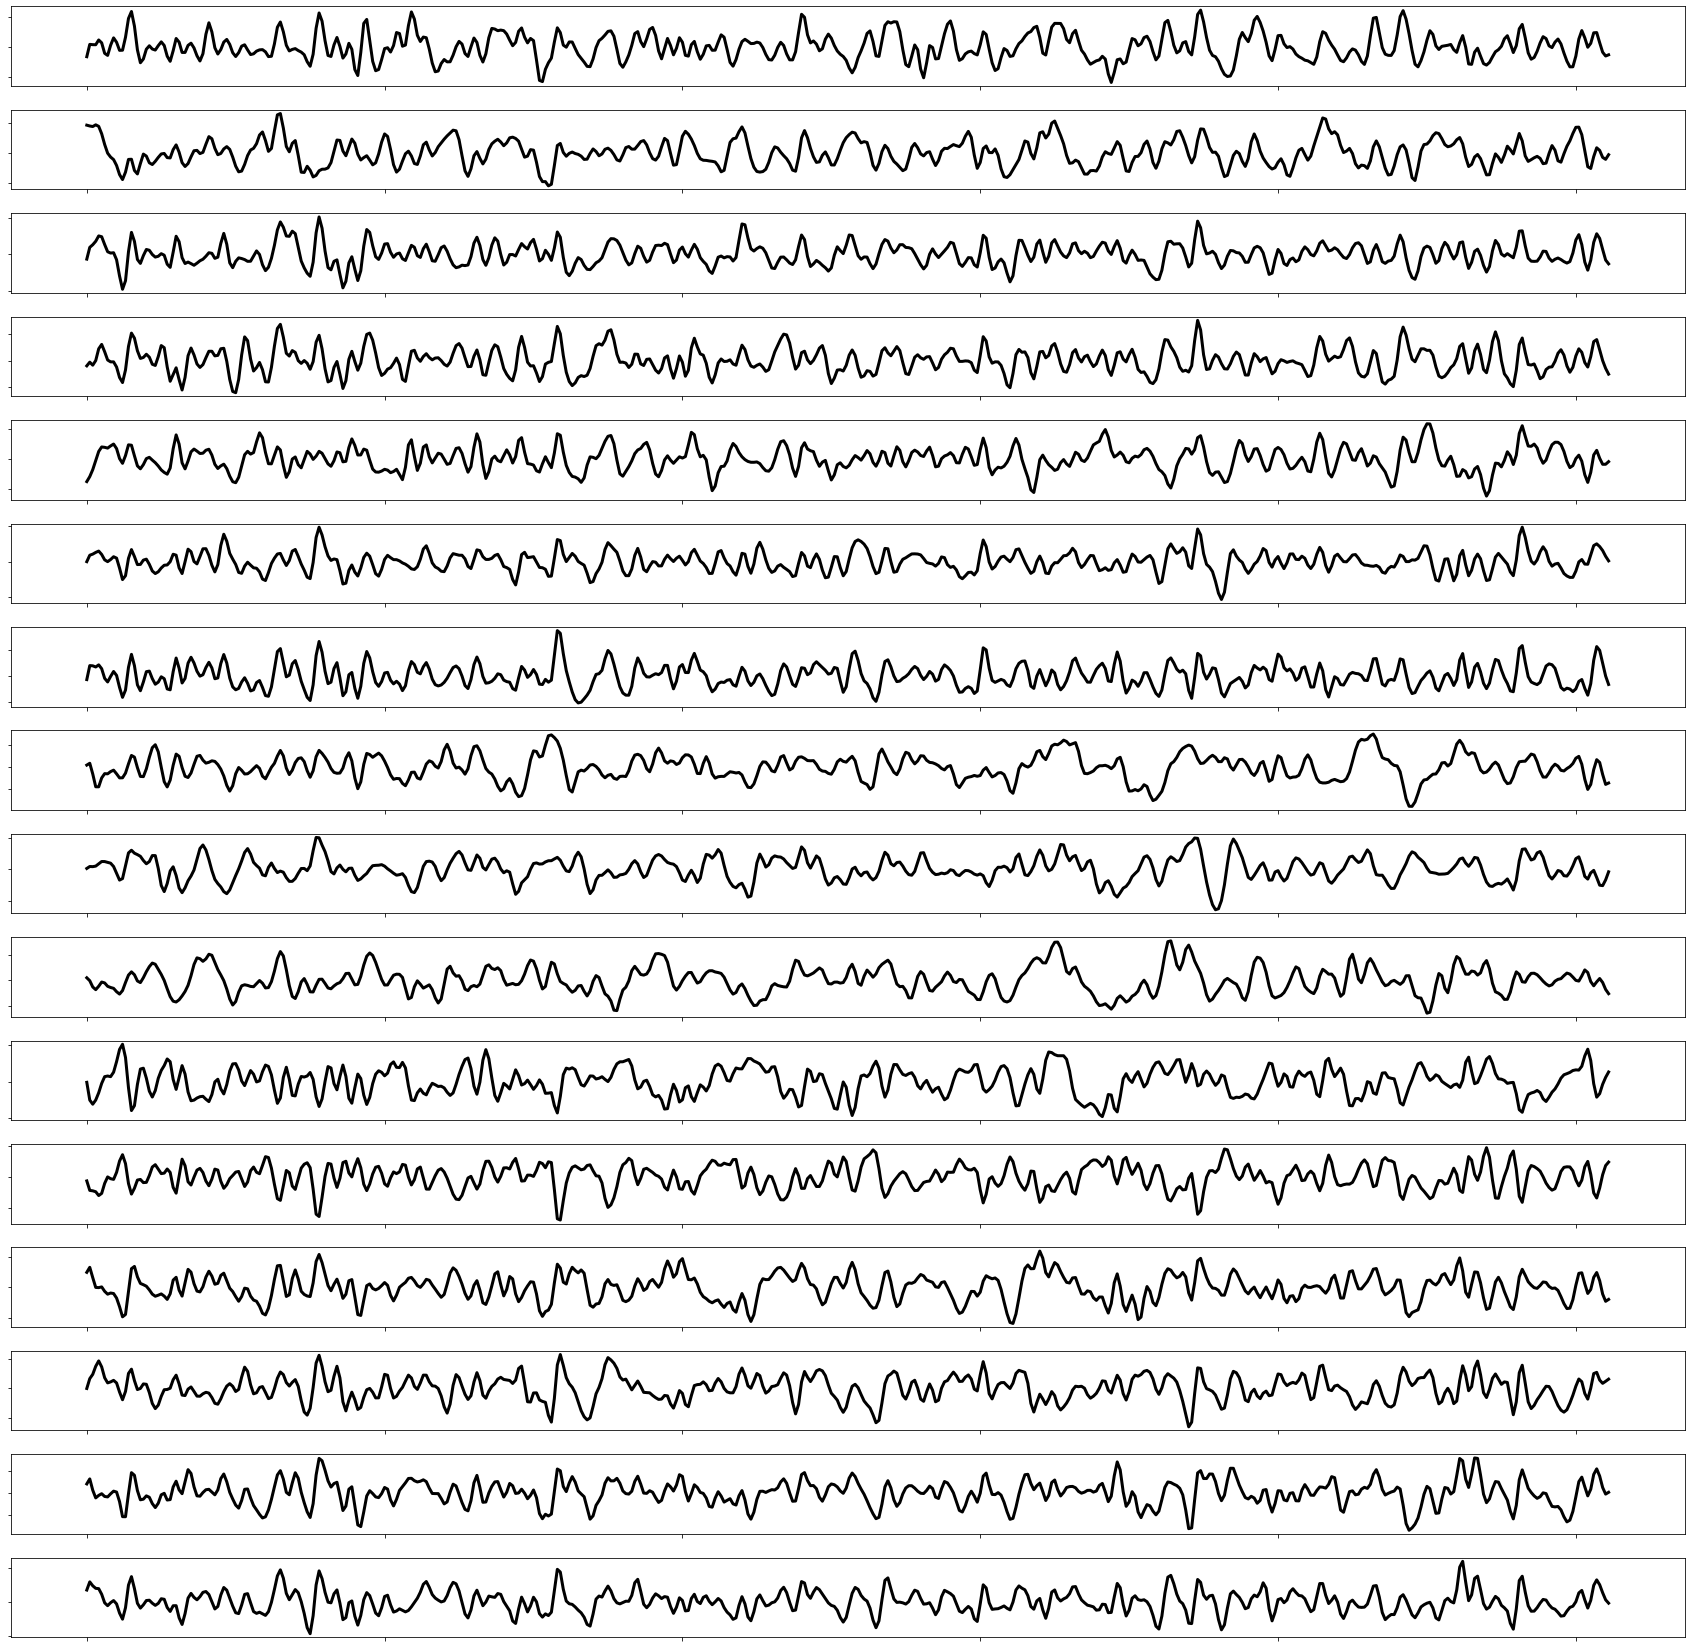

In [50]:
individual = '0179520170504'
dataPath = 'C:\\Users\\Patrick\\Documents\\GitHub\\ICDeepLearning\\Data\\Originais_CCA\\512\\'+individual+'\\1\\1.csv'
data = pd.read_csv(dataPath, header = None)

fig, axs = plt.subplots(nrows = 16, ncols = 1)
fig.set_size_inches(30, 30)
fig.subplots_adjust(hspace = 0.3)

for ax in axs:
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    
for eletrode in range(16):
    series = data.loc[:][eletrode]
    axs[eletrode].plot(series, color = 'k', linewidth = 3)
    
fig.savefig('eletrodes.png')


***

In [2]:
dataType = '512'
data = pd.read_csv('SSVEPDataset_'+dataType+'.csv')
dataset = SSVEPDataset(data, int(dataType))

batchSize = 64
dataloaders, datasetsSizes = SSVEPDataloaders(dataset, batchSize)
# example = next(iter(dataloaders['train']))['series']

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
# device = 'cpu'

In [29]:
# sample = next(iter(dataloaders['train']))[0][0][0].T[0]

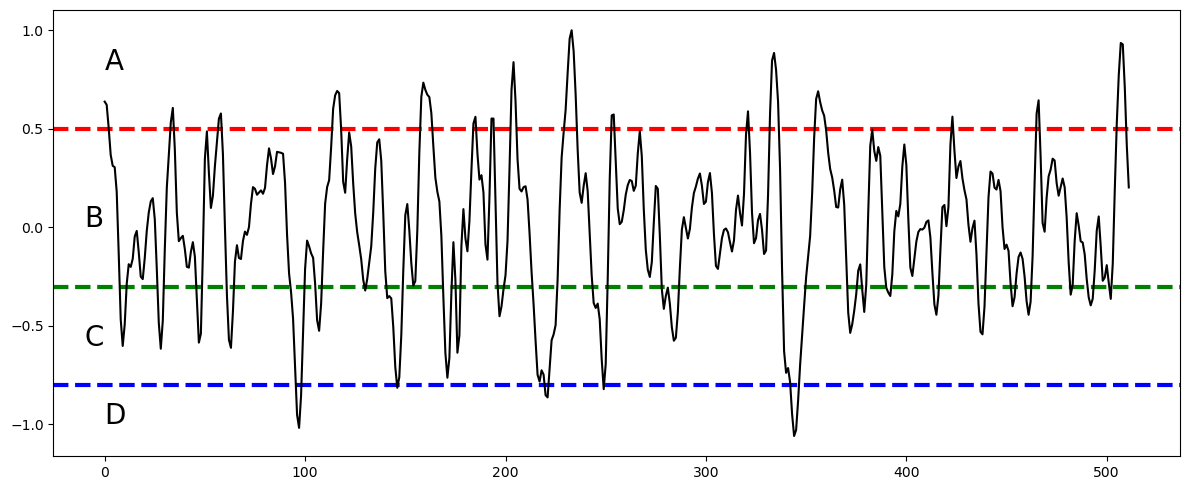

In [57]:
plt.style.use('default')
fig, axs = plt.subplots(nrows = 1, ncols = 1)
fig.set_size_inches(12, 5)

axs.axhline(y = 0.5, color = 'r', linestyle = 'dashed', linewidth = 3)
axs.axhline(y = -0.3, color = 'g', linestyle = 'dashed', linewidth = 3)
axs.axhline(y = -0.8, color = 'b', linestyle = 'dashed', linewidth = 3)
axs.plot(range(0, 512), sample, color = 'k')

axs.text(0, 0.8, 'A', fontsize = 20)
axs.text(-10, 0, 'B', fontsize = 20)
axs.text(-10, -0.6, 'C', fontsize = 20)
axs.text(0, -1, 'D', fontsize = 20)

fig.tight_layout()
fig.savefig('markovplot.png')

M = [0.3, 0.2, 0.5]
A  = uma matriz Nx3 de amostras.
K  = uma matriz 5xN para armazenar as probs de cada uma das 5 classes para cada amostra.


Para cada k em [0, 1, 2, 3, 4]:
       Temp = (A == k) (Isso aí vai retornar uma matriz de zeros e uns, indicando quem votou na classe k)
       Temp = transposta de Temp
       K[k] = M*Temp (isso vai retornar um vetor 1xN em que cada entrada é o valor do somatório dos pesos de quem votou na classe k para cada amostra)

K = K transposta

No final tu tem uma matriz de N linhas e 5 colunas, em que cada coluna você tem uma probabilidade. Aplica uma função em cada linha que retorna o argumento do valor máximo, daí no final tu tem um vetor de N linhas com as classes preditas.
Posso ter me confundindo na hora de decidir quem é linha e quem é coluna, sempre me confundo.

In [54]:
N = 50
M = np.array([[0.2, 0.3, 0.5]])
A = np.random.randint(0, 5, (N, 3))
    
predictions = np.argmax(np.array([M.dot(np.where(A == k, 1, 0).T) for k in [0, 1, 2, 3, 4]]), 
                        axis = 0)[0]
    
print(predictions.shape)
print(predictions)

(50,)
[4 3 2 2 1 4 3 2 2 4 0 1 0 3 1 1 0 3 2 3 0 3 2 0 2 0 0 3 0 3 2 1 3 0 1 3 0
 2 0 0 3 4 4 0 4 3 3 2 3 4]
